In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


## La Serie

In [1]:
import pandas as pd
import tensorflow as tf
from datetime import datetime

tf.random.set_seed(123)

# Leer el archivo Excel y parsear la fecha
df = pd.read_excel("Datos Originales/Consumo.xlsx")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.set_index("Fecha", inplace=True)

serie = df[["Gasolina superior"]].dropna()

print('\n Datos parseados:')
serie.head()


 Datos parseados:


,Gasolina superior
Fecha,
2000-01-01,308156.82
2000-02-01,307766.31
2000-03-01,331910.29
2000-04-01,315648.08
2000-05-01,319667.97


A continuación podemos ver el gráfico de la serie. 

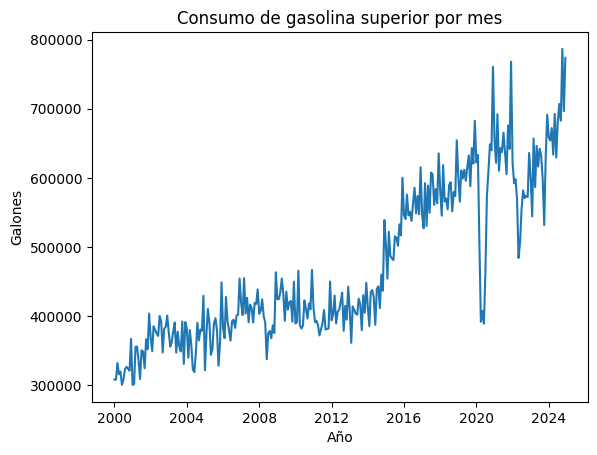

In [4]:
plt.plot(serie)
plt.gca().set(title="Consumo de gasolina superior por mes", xlabel="Año", ylabel="Galones")
plt.show()

(Como se puede ver la serie no es estacionaria en media y la LSTM funciona mejor con series estacionarizadas así que vamos a diferenciarla na vez a ver si es suficiente para estacionarizarla en media)

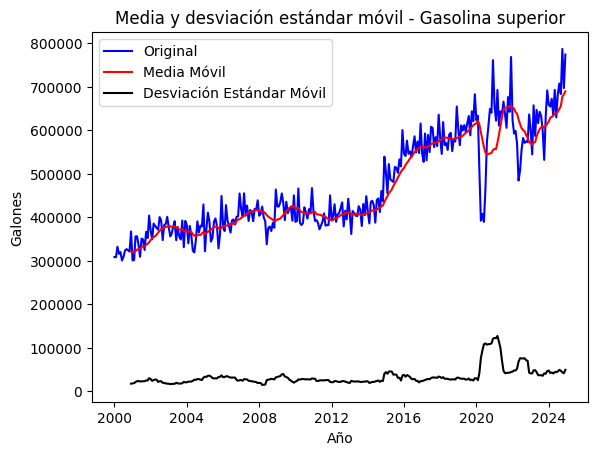

In [5]:
# Calcular media móvil y desviación estándar móvil de los últimos 12 meses
mediaMovil = serie.rolling(window=12).mean()
deMovil = serie.rolling(window=12).std()

# Graficar resultados
plt.plot(serie, color="blue", label="Original")
plt.plot(mediaMovil, color='red', label='Media Móvil')
plt.plot(deMovil, color='black', label='Desviación Estándar Móvil')
plt.legend(loc='best')
plt.title('Media y desviación estándar móvil - Gasolina superior')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.show()

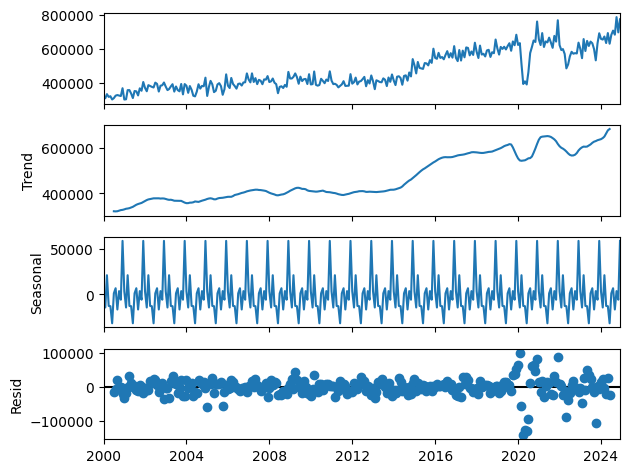

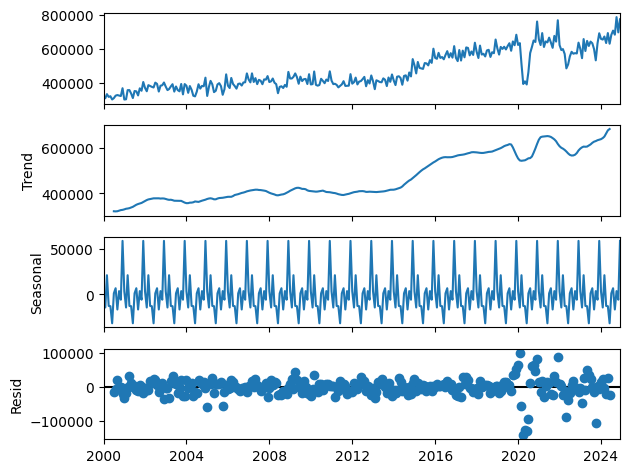

In [6]:
descomposicion = seasonal_decompose(serie)
descomposicion.plot()

En este gráfico se puede observar que hay tendencia por lo que la serie no parece ser estacionaria en media y tampoco en varianza.

In [7]:
from statsmodels.tsa.stattools import adfuller

print('Resultados del Test de Dickey-Fuller para Gasolina Superior')
dfTest = adfuller(serie["Gasolina superior"], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=[
    'Estadístico de prueba',
    'p-value',
    '# de retardos usados',
    '# de observaciones usadas'
])
for key, value in dfTest[4].items():
    salidaDf[f'Valor crítico ({key})'] = value

print(salidaDf)

Resultados del Test de Dickey-Fuller para Gasolina Superior
Estadístico de prueba         -0.179772
p-value                        0.940890
# de retardos usados          12.000000
# de observaciones usadas    287.000000
Valor crítico (1%)            -3.453342
Valor crítico (5%)            -2.871664
Valor crítico (10%)           -2.572164
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias, es decir, tiene una tendencia o depende mucho de su valor pasado (no es estacionaria). 

Como la serie no es estacionaria en media, vamos a probar con una diferenciación

In [8]:
print('Resultados del Test de Dickey-Fuller para una diferenciación de la serie Gasolina Superior')

# Diferenciar la serie
serie_diff = serie["Gasolina superior"].diff()
serie_diff.fillna(0, inplace=True)

# Prueba de Dickey-Fuller sobre la serie diferenciada
dfTest = adfuller(serie_diff)
salidaDf = pd.Series(dfTest[0:4], index=[
    'Estadístico de prueba',
    'p-value',
    '# de retardos usados',
    '# de observaciones usadas'
])
for key, value in dfTest[4].items():
    salidaDf['Valor crítico (%s)' % key] = value

print(salidaDf)

Resultados del Test de Dickey-Fuller para una diferenciación de la serie Gasolina Superior
Estadístico de prueba         -4.480786
p-value                        0.000213
# de retardos usados          16.000000
# de observaciones usadas    283.000000
Valor crítico (1%)            -3.453670
Valor crítico (5%)            -2.871808
Valor crítico (10%)           -2.572241
dtype: float64


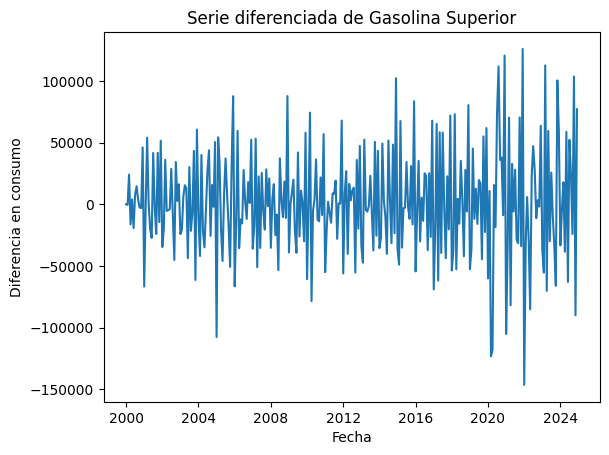

In [9]:
plt.plot(serie_diff)
plt.title("Serie diferenciada de Gasolina Superior")
plt.xlabel("Fecha")
plt.ylabel("Diferencia en consumo")
plt.show()

Como ya han podido explorarlo, las redes neuronales (como LSTM) son sensibles a la escala de los datos. Si hay valores grandes, junto con pequeños, la red puede tener dificultades al aprender, especialmente usando funciones de activación como tanh o sigmoid. (Además que esto facilita el entrenamiento). 

Como las redes neuronales trabajan mejor con los datos normalizados, vamos a normalizar la serie. 

Al normalizarla, estamos haciendo que la data tenga una media de 0 y una desviación estándar de 1. 

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
serie_diff_scaled = scaler.fit_transform(serie_diff.values.reshape(-1, 1))
serie_diff_scaled[:6]

array([[-0.03597034],
       [-0.04502189],
       [ 0.52365814],
       [-0.41290885],
       [ 0.05720588],
       [-0.48379101]])

Vamos a separar la serie en entrenamiento, validación y prueba. En este caso, tendremos 60% para entrenamiento y 20% para validación y prueba respectivamente.

In [11]:
# Largo total de la serie
total_len = len(serie_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = serie_diff_scaled[:train_end]
validation = serie_diff_scaled[train_end:val_end]
test = serie_diff_scaled[val_end:]

# Redimensionar para modelos tipo LSTM
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 300
Train: 180 | Validation: 60 | Test: 60


In [12]:
train, type(train)

(array([[-3.59703411e-02],
        [-4.50218942e-02],
        [ 5.23658137e-01],
        [-4.12908851e-01],
        [ 5.72058844e-02],
        [-4.83791011e-01],
        [ 1.48491879e-01],
        [ 3.04895466e-01],
        [ 4.38542003e-02],
        [-9.65154522e-02],
        [-1.06794323e-01],
        [ 1.03487816e+00],
        [-1.58303419e+00],
        [-7.21425850e-03],
        [ 1.21775773e+00],
        [-3.00845485e-02],
        [-4.94602762e-01],
        [-6.67252834e-01],
        [ 9.30522332e-01],
        [-8.43519135e-02],
        [-5.92741105e-01],
        [ 9.34471999e-01],
        [-3.69072873e-01],
        [ 1.16170142e+00],
        [-8.38561916e-01],
        [-4.99957529e-01],
        [ 8.01414331e-01],
        [-1.58887285e-01],
        [-1.44617256e-01],
        [-1.26739680e-01],
        [ 6.31719556e-01],
        [-2.11874948e-01],
        [-1.08282183e+00],
        [ 7.61467524e-01],
        [ 2.75168551e-02],
        [ 3.42103698e-01],
        [-5.95247796e-01],
 

In [13]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)


In [14]:
x_train

array([[-3.59703411e-02],
       [-4.50218942e-02],
       [ 5.23658137e-01],
       [-4.12908851e-01],
       [ 5.72058844e-02],
       [-4.83791011e-01],
       [ 1.48491879e-01],
       [ 3.04895466e-01],
       [ 4.38542003e-02],
       [-9.65154522e-02],
       [-1.06794323e-01],
       [ 1.03487816e+00],
       [-1.58303419e+00],
       [-7.21425850e-03],
       [ 1.21775773e+00],
       [-3.00845485e-02],
       [-4.94602762e-01],
       [-6.67252834e-01],
       [ 9.30522332e-01],
       [-8.43519135e-02],
       [-5.92741105e-01],
       [ 9.34471999e-01],
       [-3.69072873e-01],
       [ 1.16170142e+00],
       [-8.38561916e-01],
       [-4.99957529e-01],
       [ 8.01414331e-01],
       [-1.58887285e-01],
       [-1.44617256e-01],
       [-1.26739680e-01],
       [ 6.31719556e-01],
       [-2.11874948e-01],
       [-1.08282183e+00],
       [ 7.61467524e-01],
       [ 2.75168551e-02],
       [ 3.42103698e-01],
       [-5.95247796e-01],
       [-5.17064178e-01],
       [ 1.0

In [15]:
y_train, type(y_train)

(array([-4.50218942e-02,  5.23658137e-01, -4.12908851e-01,  5.72058844e-02,
        -4.83791011e-01,  1.48491879e-01,  3.04895466e-01,  4.38542003e-02,
        -9.65154522e-02, -1.06794323e-01,  1.03487816e+00, -1.58303419e+00,
        -7.21425850e-03,  1.21775773e+00, -3.00845485e-02, -4.94602762e-01,
        -6.67252834e-01,  9.30522332e-01, -8.43519135e-02, -5.92741105e-01,
         9.34471999e-01, -3.69072873e-01,  1.16170142e+00, -8.38561916e-01,
        -4.99957529e-01,  8.01414331e-01, -1.58887285e-01, -1.44617256e-01,
        -1.26739680e-01,  6.31719556e-01, -2.11874948e-01, -1.08282183e+00,
         7.61467524e-01,  2.75168551e-02,  3.42103698e-01, -5.95247796e-01,
        -5.17064178e-01,  1.05885304e-01,  3.23632512e-01,  2.70664319e-01,
        -1.04847664e+00,  6.64887028e-01, -5.34224603e-01, -1.98771277e-01,
         9.69589967e-01, -1.45918458e+00,  1.37069145e+00, -2.62657612e-01,
        -1.00881377e+00,  8.93754497e-01, -5.48028273e-01, -8.47207009e-01,
        -1.2

In [16]:
(x_train.shape[0],1,1)

(179, 1, 1)

In [17]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

59

### Creamos el modelo.   
Vamos a utilizar solo una capa lstm  

LSTM(units, input_shape=(pasos, características), stateful=False)
- units: cantidad de neuronas. Cada una es como una "mini-memoria" que puede aprender patrones en secuencias.
- input_shape: pasos (lags) y features (cant de variables)
- batch_input_shape: Solo se usa si stateful=True. Igual que input_shape, pero le agregas el tamaño fijo del batch (batch_size). O sea: (batch_size, pasos, características).
- stateful: mantiene el estado (memoria) entre batches, ayuda para entender dependencias a largo plazo entre batches

Dense(1)
#
- Toma lo que sale de la LSTM y le aplica una transformación lineal con pesos y bias.
- En este caso, Dense(1) significa: produce una sola salida (por ejemplo, una predicción de un número, como el siguiente valor de la serie).

In [18]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

# modelo1.add(LSTM(
#     units=unidades, 
#     batch_input_shape=(lote, paso, caracteristicas), 
#     stateful=True  # activamos estado entre batches
# ))
modelo1.add(Dense(1))
modelo1.summary()

C:\Users\jemil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

Compilamos el modelo. Las métricas que nos van a servir para saber como funciona el modelo en términos de la pérdida es el error medio cuadrado. 

In [19]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

Vamos a entrenar el modelo. Para eso configuramos las epochs(épocas) que es la cantidad de iteraciones. Lo pondremos en 50.

In [20]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5327 - val_loss: 0.8325
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4945 - val_loss: 0.7585
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4700 - val_loss: 0.7042
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4552 - val_loss: 0.6672
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4475 - val_loss: 0.6431
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4441 - val_loss: 0.6274
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4427 - val_loss: 0.6170
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4421 - val_loss: 0.6096
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4417 - val_loss: 0.6042
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4414 - val_loss: 0.5999
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4410 - val_loss: 0.5964
Epoch 12/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

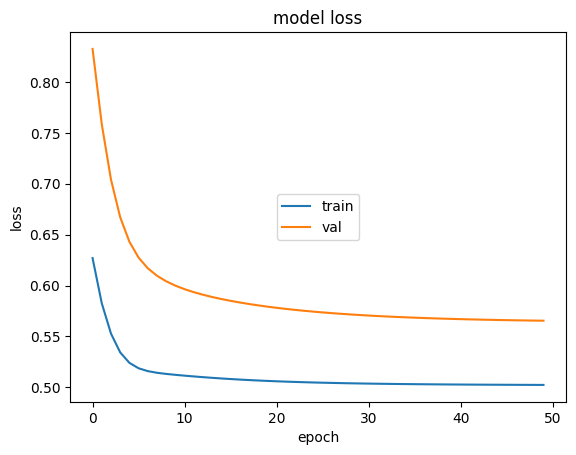

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

Evaluemos ahora el modelo según la pérdida en cada uno de los conjuntos de datos.

In [22]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4761  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5628
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.0363


1.8914971351623535

Ahora vamos a predecir con el modelo 1.  

In [23]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val1 = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n=train_end)
prediccion_test1 = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n = len(serie.values) - len(x_test))


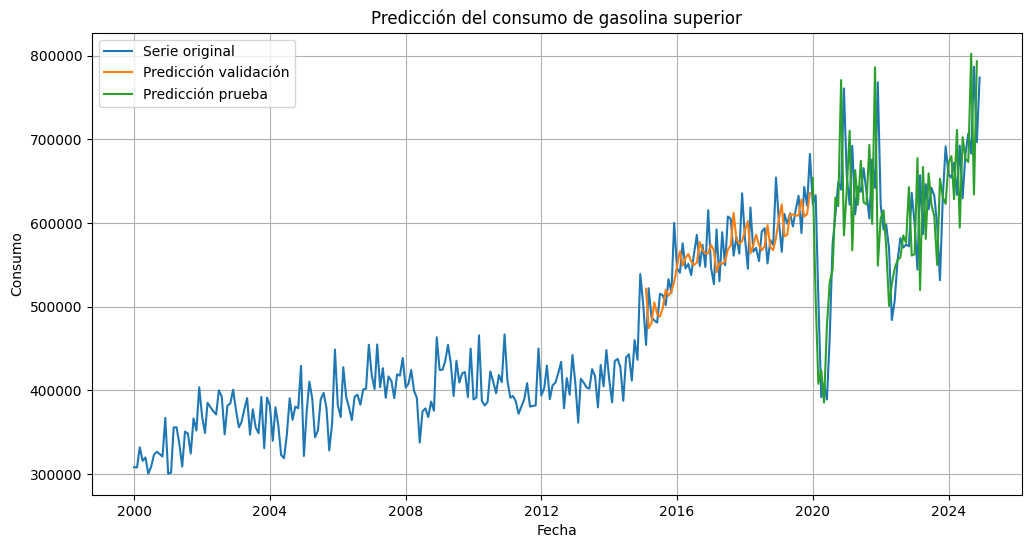

In [24]:
# df_val = pd.DataFrame(prediccion_val,index=serie[(train_prop):train_prop+val_prop].index) 
# df_test = pd.DataFrame(prediccion_test,index=serie[train_prop+len(df_val):len(serie)].index)
df_val = pd.DataFrame(prediccion_val1, index=serie[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test1, index=serie[val_end:].index[:len(prediccion_test1)])


plt.figure(figsize=(12,6))
plt.plot(serie, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.legend()
plt.title('Predicción del consumo de gasolina superior')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.show()



### Modelo 2

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

unidades = 50
paso = 12
caracteristicas = 1

modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades, 
    return_sequences=True,  # Necesario para apilar otra capa LSTM
    input_shape=(paso, caracteristicas),
    stateful=False
))
modelo2.add(Dropout(0.2))  # Regularización

modelo2.add(LSTM(
    units=25,
    stateful=False
))
modelo2.add(Dense(1))  # Capa de salida
modelo2.summary()


C:\Users\jemil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,026 (70.41 KB)

 Trainable params: 18,026 (70.41 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
modelo2.compile(loss='mean_squared_error',optimizer="rmsprop")

In [27]:
epocas = 50
history= modelo2.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5191 - val_loss: 0.7447
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4595 - val_loss: 0.6254
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4422 - val_loss: 0.5969
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4473 - val_loss: 0.5897
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4370 - val_loss: 0.5844
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4456 - val_loss: 0.5814
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4396 - val_loss: 0.5764
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4465 - val_loss: 0.5772
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4396 - val_loss: 0.5751
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4341 - val_loss: 0.5729
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4394 - val_loss: 0.5721
Epoch 12/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

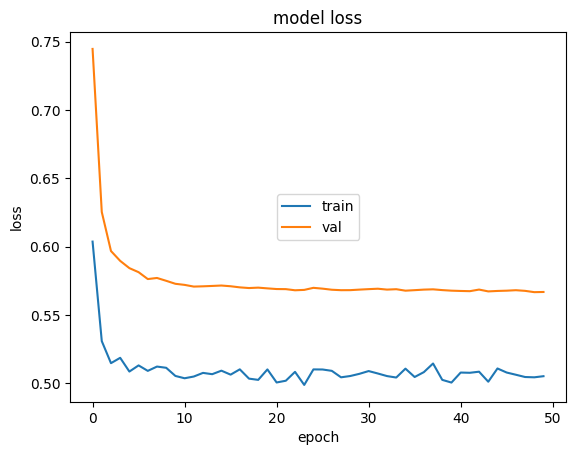

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [29]:
print("Pérdida en Train")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4743  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5636
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.1146


1.9609341621398926

In [30]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val2 = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n=train_end)
prediccion_test2 = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n = len(serie.values) - len(x_test))

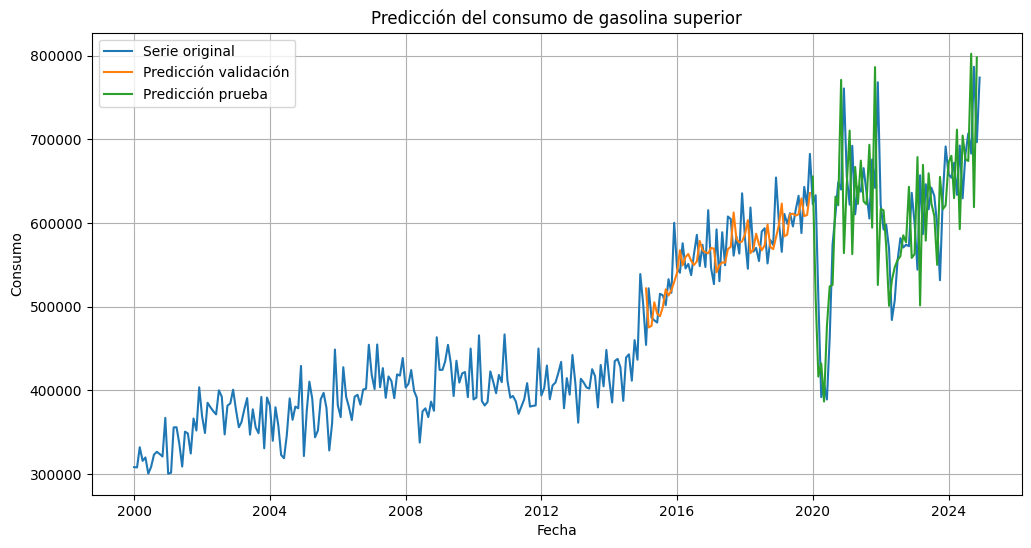

In [31]:
# df_val = pd.DataFrame(prediccion_val,index=serie[(train_prop):train_prop+val_prop].index) 
# df_test = pd.DataFrame(prediccion_test,index=serie[train_prop+len(df_val):len(serie)].index)
df_val = pd.DataFrame(prediccion_val2, index=serie[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test2, index=serie[val_end:].index[:len(prediccion_test2)])


plt.figure(figsize=(12,6))
plt.plot(serie, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.legend()
plt.title('Predicción del consumo de gasolina superior')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.show()

In [32]:
# --- Modelo 1 ---
rmse_val_1 = np.sqrt(mean_squared_error(y_val, prediccion_val1))
rmse_test_1 = np.sqrt(mean_squared_error(y_test, prediccion_test1))

# --- Modelo 2 ---
rmse_val_2 = np.sqrt(mean_squared_error(y_val, prediccion_val2))
rmse_test_2 = np.sqrt(mean_squared_error(y_test, prediccion_test2))

# Mostrar resultados
print(f"Modelo 1 - RMSE validación: {rmse_val_1:.2f} | RMSE prueba: {rmse_test_1:.2f}")
print(f"Modelo 2 - RMSE validación: {rmse_val_2:.2f} | RMSE prueba: {rmse_test_2:.2f}")


Modelo 1 - RMSE validación: 566335.45 | RMSE prueba: 616897.97
Modelo 2 - RMSE validación: 566204.78 | RMSE prueba: 616035.71
